In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.vocab import GloVe
import spacy
import io
import jsonlines
import json
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import fasttext
import re
from spacy.language import Language
from spacy.tokens import Doc
from gensim import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.bernoulli import Bernoulli
import seaborn as sns
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split


device_cpu = torch.device('cpu')


use_word2vec = True
use_glove = True
use_fasttext = True
use_word_dropout = False

LEARNING_RATE = 0.001

word_vector_types_count = 0
if use_word2vec:
    word_vector_types_count += 1
if use_glove:
    word_vector_types_count += 1
if use_fasttext:
    word_vector_types_count += 1

device_fast = torch.device('cpu')
if torch.has_mps:
    device_fast = torch.device('mps')
else:
    if torch.cuda.is_available():
        device_fast = torch.device('cuda')
    else:
        device_fast = torch.device('cpu')

device_fast = torch.device('cpu')
EMBED_DIM = 300
HIDDEN_LAYER_DIM = 128
NUM_EPOCHS = 150
BATCH_SIZE = 32
EXPAND_CONTRACTIONS = False
PATIENCE_PARAMETER = 4
VALIDATION_LOSS_STEP = 4

In [3]:
glove = None
fasttext_model = None
word2vec_model = None

if use_glove:
    glove = GloVe()
if use_fasttext:
    fasttext_model = fasttext.load_model('./crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
if use_word2vec:
    word2vec_model = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin',binary=True)

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:

def preprocess_text(text):    
    words = nlp(text)
    #sentence = [token.text_with_ws for token in words if not token.is_punct]
    sentence  = " ".join([token.text for token in words if not token.is_punct ]).strip()
    sentence = sentence.lower()
    return sentence

def process_training_data():
    negative_reviews = io.open('./Train.neg',encoding='latin-1').readlines()
    positive_reviews = io.open('./Train.pos',encoding='latin-1').readlines()
    with jsonlines.open('train.jsonl',mode='w') as writer:

        for review in positive_reviews:
            processed_text = preprocess_text(review)
            d = {'text': processed_text , 'sentiment': 1}
            writer.write(d)
        for review in negative_reviews:
            processed_text = preprocess_text(review)
            d = {'text': processed_text , 'sentiment': 0}
            writer.write(d)
process_training_data()


- Almost equal distribution of the positive and negative classes

In [7]:
from torch.utils.data import SubsetRandomSampler

class ReviewDataSet(Dataset):

    def __init__(self,file):
        super().__init__()
        
        self.file = file
        self.labels = []
        self.data = []
        with open(self.file) as f:
            for line in f:
                sample = json.loads(line)
                self.data.append([sample['text'],sample['sentiment']])
                self.labels.append(sample['sentiment'])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]


dataset = ReviewDataSet('train.jsonl') 

train_idx , valid_idx = train_test_split(np.arange(len(dataset.labels)),test_size=0.2,
    shuffle = True,
    stratify = dataset.labels,
    random_state = 0
)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size


#train_dataset = torch.utils.data.Subset(dataset,range(train_size))
#validation_dataset = torch.utils.data.Subset(dataset,range(train_size,train_size+test_size))
#train_dataset,validation_dataset = random_split(dataset,[train_size,test_size])

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
val_dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,sampler= valid_sampler)


#train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
#val_dataloader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [8]:
def getWordEmbeddings(batch_data,dicts):
    

    word2vec,glove,fast_text = dicts
    if(len(batch_data)==2):
        reviews = batch_data[0]
        sentiment = batch_data[1]
    else:
        reviews = batch_data[0]
        sentiment = None
    
    reviews_tensor = []
    lengths = []
    for review in reviews:
        
        preprocessed_review_list = []
        i = 0
        review_doc = nlp(review)
        for token in review_doc:
            if token.text == '\'s':
                if i>0 and review_doc[i-1].pos_!='PROPN':
                    preprocessed_review_list[i-1] = preprocessed_review_list[i-1] + '\'s'
            elif token.text == '\'nt':
                if i>0:
                    preprocessed_review_list[i-1] = preprocessed_review_list[i-1] + '\'nt'
            else:
                preprocessed_review_list.append(token.text) 
                i+=1

        new_review = " ".join(preprocessed_review_list)
        
        words = new_review.split()
        words_tensor = []
        lengths.append(len(words))
        for word in words:
            #words_tensor.append(glove.__getitem__(word))
            word_embeddings = []
            if use_word2vec:
                try:
                    word_embeddings.append(torch.tensor(word2vec.get_vector(word)))
                except:
                    word_embeddings.append(torch.zeros(EMBED_DIM,))
            if use_glove:
                word_embeddings.append(glove.__getitem__(word))
            if use_fasttext:
                word_embeddings.append(torch.tensor(fast_text.get_word_vector(word)))
            word_tensor = torch.stack(word_embeddings)
            word_tensor = word_tensor.squeeze()
            words_tensor.append(word_tensor)            
        reviews_tensor.append(torch.stack(words_tensor,dim=0))
    
    mask = torch.zeros((len(lengths),max(lengths)))
    for i in range(len(lengths)):
        mask[i,:lengths[i]] = 1.0
    
    return (pad_sequence(reviews_tensor,batch_first=True),mask,sentiment)


In [8]:
def plot_sentence_embeddings_tsne(index):
    
    all_vectors = None
    all_labels = None



    for i,data in enumerate(train_dataloader,0):
        input_reviews , input_mask , output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
        inp_lengths = torch.sum(input_mask,-1,keepdim=True).int()
        
        input_reviews  = input_reviews[:,:,index,:]
        total = torch.sum(input_reviews*(input_mask.unsqueeze(2)),axis=1)
        vector_average = total / inp_lengths
        vector_average = vector_average.numpy()

        if(all_vectors is None):
            all_vectors = vector_average
            all_labels = output_labels.numpy()
        else:
            all_vectors = np.append(all_vectors,vector_average,axis=0)
            all_labels = np.append(all_labels,output_labels.numpy(),axis=0)

    
    tsne = TSNE()
    out = tsne.fit_transform(all_vectors)

    for i in range(len(out)):
        if int(all_labels[i])==1:
            plt.scatter(out[i][0],out[i][1],c='r')
        else:
            plt.scatter(out[i][0],out[i][1],c='b')
    plt.show()




In [11]:
class DAN(nn.Module):

    def __init__(self,embed_dim=EMBED_DIM,hidden_dim = HIDDEN_LAYER_DIM, word_droput_prob = 0.3,fc_dropout = 0.3,device_train=device_cpu):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(self.embed_dim,self.hidden_dim)
        #self.fc = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim,1)
        self.sigmoid  = nn.Sigmoid()
        self.word_dropout_prob = word_droput_prob
        self.fc_dropout = nn.Dropout(p=fc_dropout)
        self.device_train = device_train

        self.importance_weights = nn.Linear(word_vector_types_count*EMBED_DIM,word_vector_types_count)
        

    def forward(self,inp,inp_mask):
    
        inp_lengths = torch.sum(inp_mask,-1,keepdim=True).int()
        inp_lengths = inp_lengths.to(self.device_train)
        if word_vector_types_count > 1:
            inp_ = inp.view((inp.shape[0],inp.shape[1],-1))
            inp_ = inp_.to(self.device_train)
            out = self.importance_weights(inp_)
            weights = F.softmax(out,dim=2).unsqueeze(3)
            weights = weights.to(self.device_train)
            weights_multiplied_vector = weights * inp
            inp = torch.sum(weights_multiplied_vector,dim=2)
            inp = torch.nn.functional.normalize(inp,dim=2)

        total = torch.sum(inp*(inp_mask.unsqueeze(2)),axis=1)
        vector_average = total / inp_lengths
        
        ans = F.relu(self.fc1(vector_average))
        #ans = F.relu(self.fc(ans))
        ans = self.sigmoid(self.fc2(ans))
        return ans
    


In [12]:
'''inp = torch.randn((2,3,5))
mask = torch.tensor([[1.0,0.0,0.0],[1.0,0.0,1.0]])

print(inp)'''

'inp = torch.randn((2,3,5))\nmask = torch.tensor([[1.0,0.0,0.0],[1.0,0.0,1.0]])\n\nprint(inp)'

In [15]:
# Training loop
dan = DAN(EMBED_DIM,HIDDEN_LAYER_DIM,device_train=device_fast)

criterion = nn.BCELoss()
optimizer = optim.Adagrad(dan.parameters(),lr=LEARNING_RATE)
#optimizer = optim.Adam(dan.parameters(),lr=LEARNING_RATE)



validation_losses = []
validation_accuracy = []
training_losses = []

best_validation_loss = 1000.0
validation_loss_not_decreased_steps = 0

for e in range(NUM_EPOCHS):
    if validation_loss_not_decreased_steps >= PATIENCE_PARAMETER:
        break

    training_loss = 0.0
    size = 0
    dan.train()

    for i,data in enumerate(train_dataloader,0):
        
        optimizer.zero_grad()
        
        input_reviews , input_mask , output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
        #break
        #print(input_mask)
        input_reviews = input_reviews.to(device_fast)
        input_mask = input_mask.to(device_fast)
        output = dan(input_reviews,input_mask).squeeze()
        output = output.to(device_cpu)
        #print(output)
        loss = criterion(output,output_labels.float())

        training_loss += loss.item()
        loss.backward()
        optimizer.step()   
     
    
    if e%VALIDATION_LOSS_STEP==0:
        dan.eval()
        correct_count = 0
        validation_loss = 0

        val_size = 0
        for i,data in enumerate(val_dataloader,0):
            input_reviews,input_mask,output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
            input_reviews = input_reviews.to(device_fast)
            input_mask = input_mask.to(device_fast)
            output = dan(input_reviews,input_mask).squeeze()
            output = output.to(device_cpu)
            loss = criterion(output,output_labels.float())
            validation_loss += loss.item()
            nearest_class = torch.round(output)
            correct = (nearest_class == output_labels.float()).float()
            
            correct_count += correct.sum()
        correct_count = int(correct_count)
        
        current_validation_loss = validation_loss/len(valid_sampler)

        if current_validation_loss <= best_validation_loss:
            validation_loss_not_decreased_steps = 0
            torch.save(dan.state_dict(),'best_model.pth')
            best_validation_loss = current_validation_loss

        elif current_validation_loss < validation_losses[-1]:
            validation_loss_not_decreased_steps = 0
        else:
            validation_loss_not_decreased_steps+=1

        validation_losses.append(validation_loss/len(valid_sampler))
        validation_accuracy.append(100*(correct_count/len(valid_sampler)))


        print("Validation Loss = " + str(validation_loss/len(valid_sampler)) + " Validation Set Accuracy = " + str(100*(correct_count/len(valid_sampler))))
    training_losses.append(training_loss/len(train_sampler))
    print("Epoch " + str(e) + "; Training Loss (averaged) = " + str(training_loss/len(train_sampler) ))


Validation Loss = 0.02145250219106674 Validation Set Accuracy = 70.05
Epoch 0; Training Loss (averaged) = 0.021443212240934373
Epoch 1; Training Loss (averaged) = 0.021112841807305813
Epoch 2; Training Loss (averaged) = 0.020816395439207554
Epoch 3; Training Loss (averaged) = 0.02053834380209446
Validation Loss = 0.020361190527677535 Validation Set Accuracy = 70.35
Epoch 4; Training Loss (averaged) = 0.02027620556205511
Epoch 5; Training Loss (averaged) = 0.02003412615507841
Epoch 6; Training Loss (averaged) = 0.019807146914303304
Epoch 7; Training Loss (averaged) = 0.019591113440692424
Validation Loss = 0.019535924077033997 Validation Set Accuracy = 71.2
Epoch 8; Training Loss (averaged) = 0.019379258021712302
Epoch 9; Training Loss (averaged) = 0.019180088460445405
Epoch 10; Training Loss (averaged) = 0.0189965617954731
Epoch 11; Training Loss (averaged) = 0.018824694067239762
Validation Loss = 0.018880629807710648 Validation Set Accuracy = 72.3
Epoch 12; Training Loss (averaged) = 0

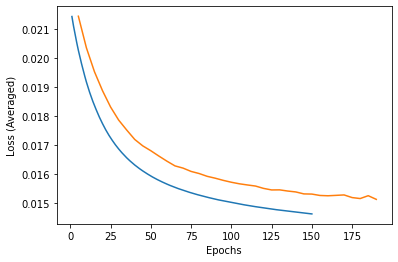

In [16]:
epochs = np.linspace(1,len(training_losses),len(training_losses))
plt.plot(epochs,training_losses) 
epochs = 5*np.linspace(1,len(validation_accuracy),len(validation_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Loss (Averaged)')
plt.plot(epochs,validation_losses)
plt.show()


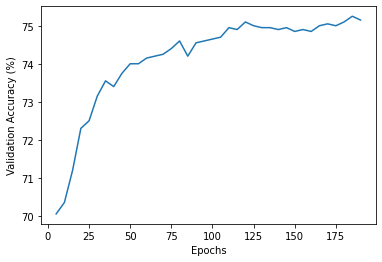

In [17]:
epochs = 5*np.linspace(1,len(validation_accuracy),len(validation_accuracy))
plt.plot(epochs,validation_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()

In [18]:
dan_model = DAN()
dan_model.load_state_dict(torch.load('best_model.pth'))
dan_model.eval()

correct_count = 0


def test(filename):
    reviews = open(filename,'r',encoding='latin-1').readlines()
    for i in range(len(reviews)):
        r = reviews[i]
        reviews[i] = preprocess_text(r)
    
    reviews,reviews_mask,labels = getWordEmbeddings([reviews],(word2vec_model,glove,fasttext_model))
    

    output = dan_model(reviews,reviews_mask)
    answers = torch.round(output)
    print(answers.shape)
    correct_count=0
    for i in range(answers.shape[0]):
        if i<331:
            if(int(answers[i])==1):
                correct_count+=1
        else:

            if(int(answers[i])==0):
                correct_count+=1
    print(answers)

    print("Test Set Accuracy = " + str((100.0*correct_count)/answers.shape[0]))

test('./TestData')


torch.Size([662, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],